In [1]:
from pathlib import Path
from functools import reduce

import matplotlib.pyplot as plt
from cytoolz import groupby

from lhotse.recipes.librimix import prepare_librimix
from lhotse.features import FeatureSetBuilder, FeatureExtractor
from lhotse.cut import make_cuts_from_features, CutSet
from lhotse.manipulation import combine
from lhotse.dataset.source_separation import PreMixedSourceSeparationDataset, DynamicallyMixedSourceSeparationDataset

# Download MiniLibriMix

In [2]:
%%bash
if [ ! -d MiniLibriMix ]; then
  wget https://zenodo.org/record/3871592/files/MiniLibriMix.zip
  unzip MiniLibriMix.zip
fi

# Prepare audio and supervision manifests

In [3]:
root_dir = Path('.')
librimix_csv = root_dir / 'MiniLibriMix/metadata/mixture_train_mix_both.csv'

In [4]:
librimix_manifests = prepare_librimix(librimix_csv, 'librimix_nb', with_precomputed_mixtures=True)

# Extract features

In [5]:
for partition, manifests in librimix_manifests.items():
    feature_set_builder = FeatureSetBuilder(
        feature_extractor=FeatureExtractor(type='fbank'),
        output_dir=f'librimix_nb/feats_{partition}',
        root_dir=root_dir
    )
    feature_set = feature_set_builder.process_and_store_recordings(
        recordings=manifests['audio'],
        num_jobs=8
    )
    librimix_manifests[partition]['feats'] = feature_set
    librimix_manifests[partition]['cuts'] = make_cuts_from_features(feature_set)

# Prepare dynamically-mixed audio cuts

In [6]:
# TODO: refactor the library to re-use this function from the CLI script
def mix_by_recording_id(cut_sets):
    all_cuts = combine(*cut_sets)
    recording_id_to_cut = groupby(lambda cut: cut.recording_id, all_cuts)
    mixed_cuts = (
        reduce(lambda left_cut, right_cut: left_cut.overlay(right_cut), cuts[1:], cuts[0])
        for recording_id, cuts in recording_id_to_cut.items()
    )
    return CutSet(cuts={cut.id: cut for cut in mixed_cuts})

In [7]:
clean_cut_set = mix_by_recording_id(cut_sets=[librimix_manifests['sources']['cuts']])
noisy_cut_set = mix_by_recording_id(cut_sets=[librimix_manifests['sources']['cuts'], librimix_manifests['noise']['cuts']])

# Source separation datasets illustration

## Pre-mixed noisy

In [8]:
premix_dataset = PreMixedSourceSeparationDataset(
    sources_set=librimix_manifests['sources']['cuts'],
    mixtures_set=librimix_manifests['premixed']['cuts'],
    root_dir=root_dir
)

# ALTERNATIVELY, when the manifests are already dumped (e.g. using the bash script)
# source_cuts = CutSet.from_yaml('librimix/cuts_sources.yml')
# mixed_cuts = CutSet.from_yaml('librimix/cuts_mix.yml')

In [9]:
sample = premix_dataset[0]
sample.keys()

dict_keys(['sources', 'mixture', 'real_mask', 'binary_mask'])

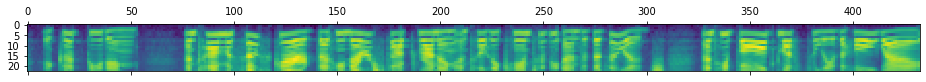

In [10]:
plt.matshow(sample['sources'][0].T);

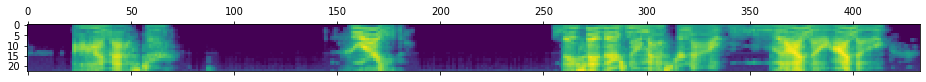

In [11]:
plt.matshow(sample['sources'][1].T);

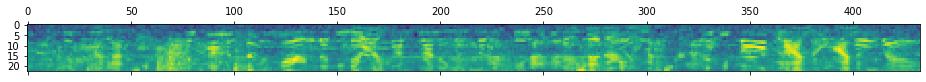

In [12]:
plt.matshow(sample['mixture'].T);

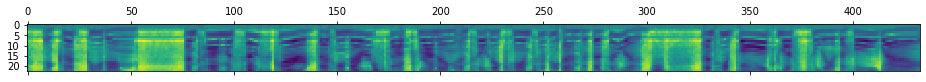

In [13]:
plt.matshow(sample['real_mask'][0].T);

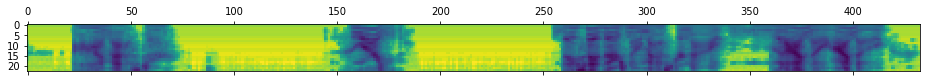

In [14]:
plt.matshow(sample['real_mask'][1].T);

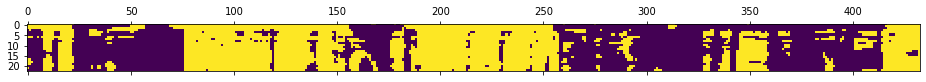

In [15]:
plt.matshow(sample['binary_mask'].T);

## Dynamically-mixed noisy

In [16]:
dset_dyn_noise = DynamicallyMixedSourceSeparationDataset(
    sources_set=librimix_manifests['sources']['cuts'],
    mixtures_set=noisy_cut_set,
    nonsources_set=librimix_manifests['noise']['cuts'],
    root_dir=root_dir
)

In [17]:
sample_dyn_noise = dset_dyn_noise[0]

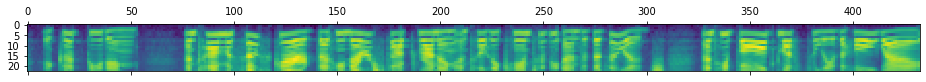

In [18]:
plt.matshow(sample_dyn_noise['sources'][0].T);

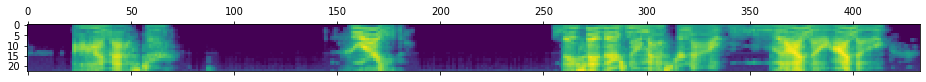

In [19]:
plt.matshow(sample_dyn_noise['sources'][1].T);

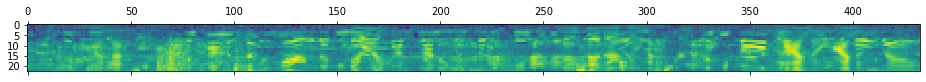

In [20]:
plt.matshow(sample_dyn_noise['mixture'].T);

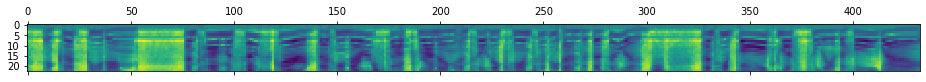

In [21]:
plt.matshow(sample_dyn_noise['real_mask'][0].T);

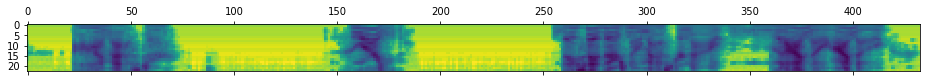

In [22]:
plt.matshow(sample_dyn_noise['real_mask'][1].T);

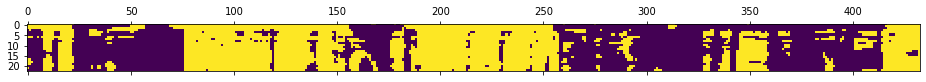

In [23]:
plt.matshow(sample_dyn_noise['binary_mask'].T);

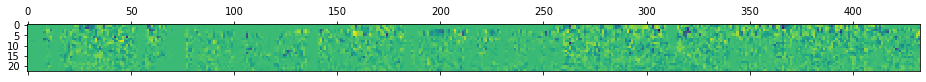

In [24]:
plt.matshow((sample['mixture'] - sample_dyn_noise['mixture']).T)

In [25]:
diff = (sample_dyn_noise['mixture'] - sample['mixture'])
diff.min(), diff.max()

(tensor(-0.9241), tensor(1.9798))

## Dynamically-mixed clean

In [26]:
dset_dyn_clean = DynamicallyMixedSourceSeparationDataset(
    sources_set=librimix_manifests['sources']['cuts'],
    mixtures_set=clean_cut_set,
    root_dir=root_dir
)

In [27]:
sample_dyn_clean = dset_dyn_clean[0]

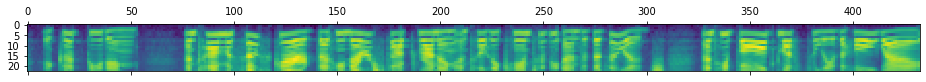

In [28]:
plt.matshow(sample_dyn_clean['sources'][0].T);

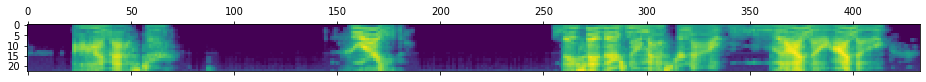

In [29]:
plt.matshow(sample_dyn_clean['sources'][1].T);

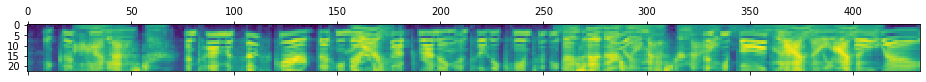

In [30]:
plt.matshow(sample_dyn_clean['mixture'].T);

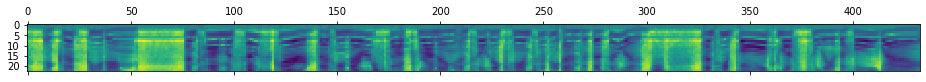

In [31]:
plt.matshow(sample_dyn_clean['real_mask'][0].T);

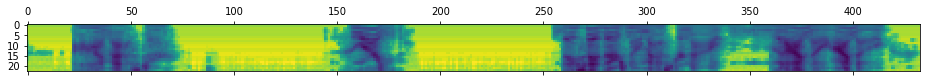

In [32]:
plt.matshow(sample_dyn_clean['real_mask'][1].T);

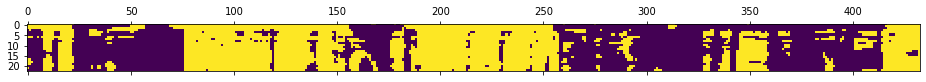

In [33]:
plt.matshow(sample_dyn_clean['binary_mask'].T);

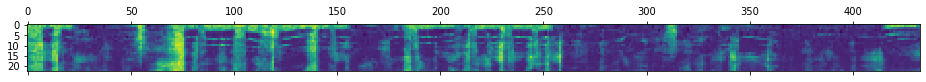

In [34]:
plt.matshow((sample['mixture'] - sample_dyn_clean['mixture']).T)

In [35]:
diff = (sample_dyn_clean['mixture'] - sample['mixture'])
diff.min(), diff.max()

(tensor(-13.6359), tensor(1.5852))